<a href="https://colab.research.google.com/github/DaeYejun2/PyTorch/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 파이토치 사전훈련 모델 사용

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
#GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2026-01-16 14:53:23--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.129.123, 52.85.129.88, 52.85.129.24, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.129.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  44.4MB/s    in 1.0s    

2026-01-16 14:53:25 (44.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/

In [4]:
#전처리 설정
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [5]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
print(class_names)

['ants', 'bees']


In [7]:
model_ft = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [8]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
#데이터의 클래스 수에 맞게 out_features 변경
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  #out_features를 2로 바꾸고 넘겨줌

model_ft = model_ft.to(device)

In [13]:
#손실함수와 옵티마이저
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [14]:
#7에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
#모델 학습
#학습 함수 정의
def train_model(model,criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-'*10)

      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
              loss.backward()
              optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f}\tAccuracy: {:4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

      print()
    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2679	Accuracy: 0.877049
val Loss: 0.2148	Accuracy: 0.928105

Epoch 1/24
----------
train Loss: 0.2672	Accuracy: 0.889344
val Loss: 0.2558	Accuracy: 0.915033

Epoch 2/24
----------
train Loss: 0.2601	Accuracy: 0.885246
val Loss: 0.2234	Accuracy: 0.928105

Epoch 3/24
----------
train Loss: 0.3080	Accuracy: 0.877049
val Loss: 0.2343	Accuracy: 0.915033

Epoch 4/24
----------
train Loss: 0.2047	Accuracy: 0.918033
val Loss: 0.2109	Accuracy: 0.901961

Epoch 5/24
----------
train Loss: 0.2811	Accuracy: 0.893443
val Loss: 0.2165	Accuracy: 0.934641

Epoch 6/24
----------
train Loss: 0.2812	Accuracy: 0.868852
val Loss: 0.2137	Accuracy: 0.921569

Epoch 7/24
----------
train Loss: 0.2481	Accuracy: 0.905738
val Loss: 0.2219	Accuracy: 0.908497

Epoch 8/24
----------
train Loss: 0.2236	Accuracy: 0.913934
val Loss: 0.2338	Accuracy: 0.901961

Epoch 9/24
----------
train Loss: 0.2158	Accuracy: 0.922131
val Loss: 0.2057	Accuracy: 0.921569

Epoch 10/24
----------
train L

In [19]:
# 결과 시각화
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10,5))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [27]:

def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predictes: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

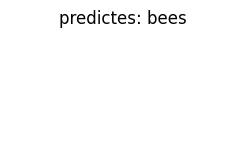

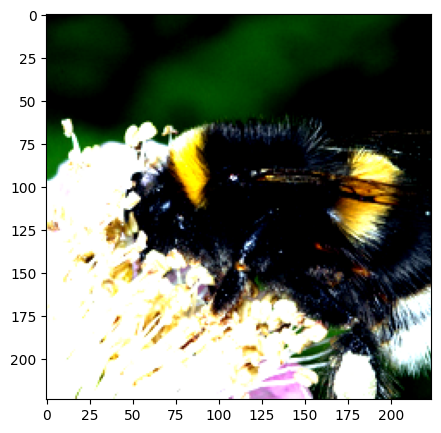

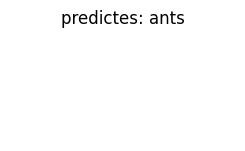

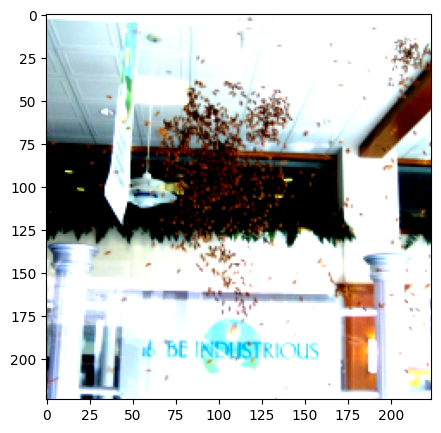

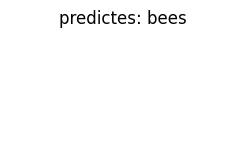

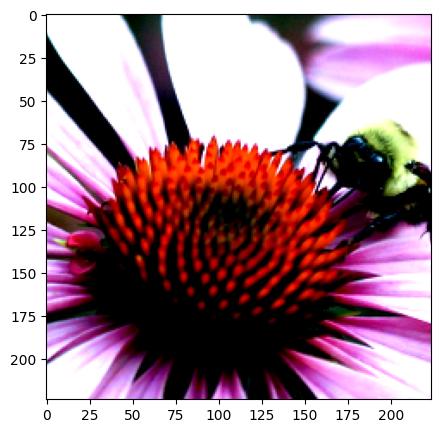

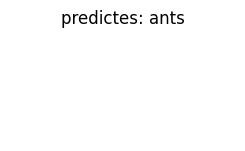

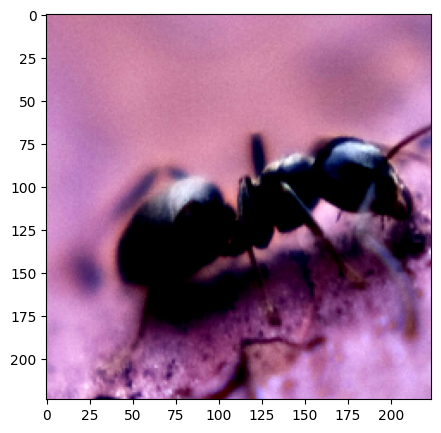

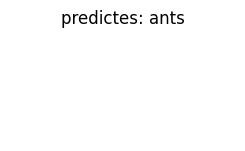

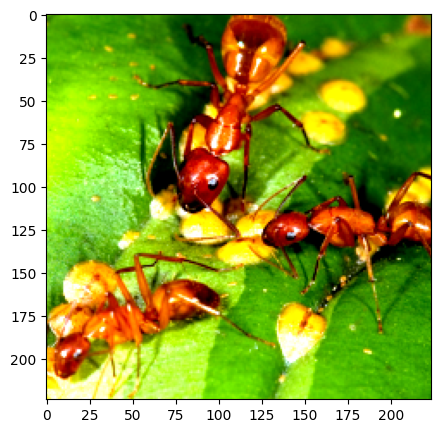

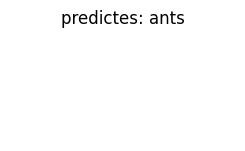

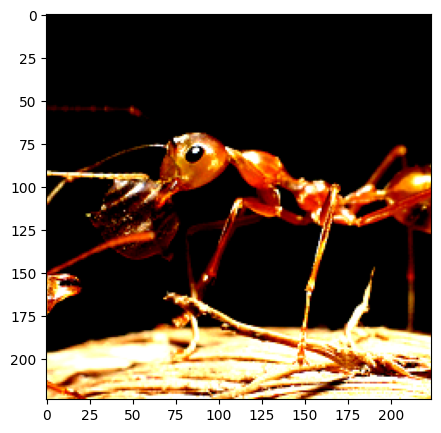

In [28]:
visualize_model(model_ft)

In [29]:
# 고정된 특징 추출기로써의 합성곱 신경망
# 마지막 계층을 제외한 신경망의 모든 부분을 고정
# requires_grad == False로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다

In [30]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6070	Accuracy: 0.668033
val Loss: 0.3684	Accuracy: 0.843137

Epoch 1/24
----------
train Loss: 0.4672	Accuracy: 0.786885
val Loss: 0.1744	Accuracy: 0.947712

Epoch 2/24
----------
train Loss: 0.5658	Accuracy: 0.836066
val Loss: 0.1520	Accuracy: 0.954248

Epoch 3/24
----------
train Loss: 0.4057	Accuracy: 0.831967
val Loss: 0.1704	Accuracy: 0.947712

Epoch 4/24
----------
train Loss: 0.5895	Accuracy: 0.762295
val Loss: 0.1498	Accuracy: 0.954248

Epoch 5/24
----------
train Loss: 0.5093	Accuracy: 0.778689
val Loss: 0.3108	Accuracy: 0.895425

Epoch 6/24
----------
train Loss: 0.4220	Accuracy: 0.827869
val Loss: 0.1763	Accuracy: 0.954248

Epoch 7/24
----------
train Loss: 0.3459	Accuracy: 0.868852
val Loss: 0.1700	Accuracy: 0.954248

Epoch 8/24
----------
train Loss: 0.3247	Accuracy: 0.864754
val Loss: 0.1706	Accuracy: 0.947712

Epoch 9/24
----------
train Loss: 0.3541	Accuracy: 0.868852
val Loss: 0.1736	Accuracy: 0.954248

Epoch 10/24
----------
train Loss: 0.3480	Accuracy: 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


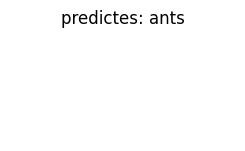

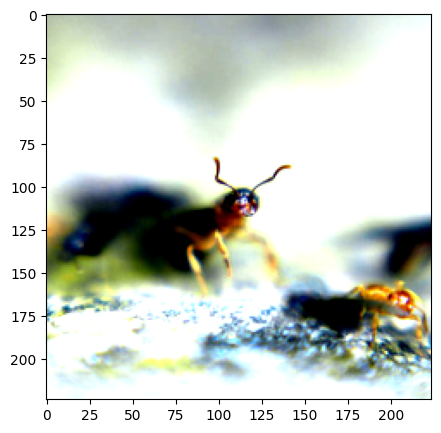

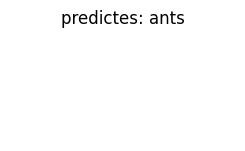

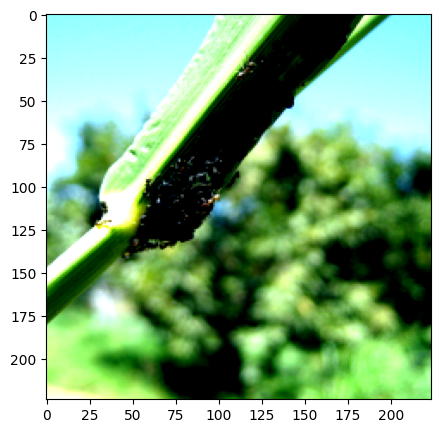

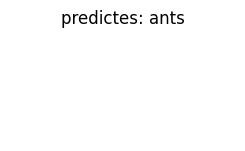

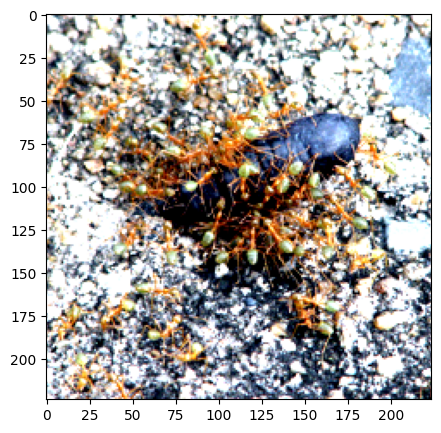

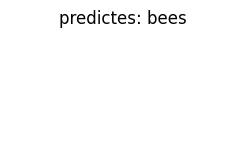

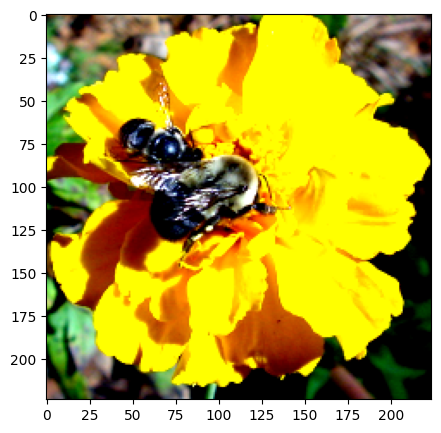

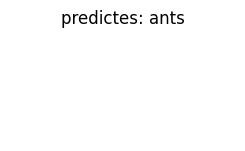

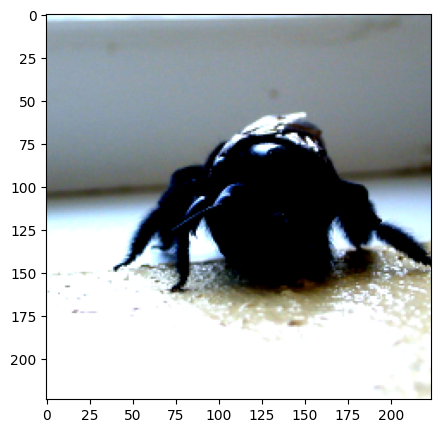

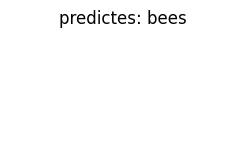

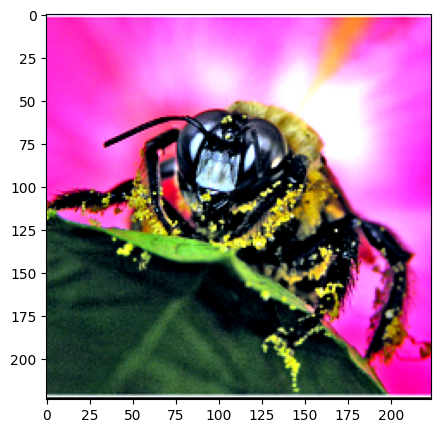

In [32]:
visualize_model(model_ft)